# Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-26 15:07:27.262382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:07:27.359572: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-26 15:07:27.732474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-26 15:07:27.732530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-26 15:07:28.380976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:07:28.381770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:07:28.381996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 15:07:28.382157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #10
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [4]:
idx = 400
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

pc1 = np.load(fn1)

#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(gt[idx, 2:])

offset = 0#for debug 
rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# print(rot_m)

initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# pc1 = pc1 @ rot_m
# rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# pc1 = pc1 @ rotcorr
# pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [35]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

<IPython.core.display.Javascript object>


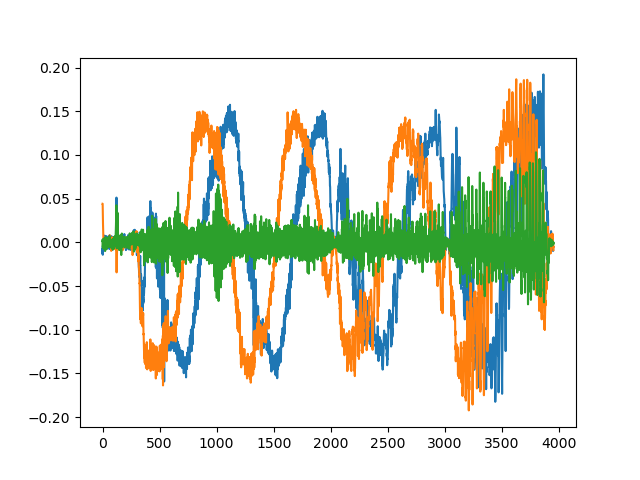

In [36]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# ax.plot(poses[:,:3,3])
ax.plot(np.diff(poses[:,:3,3], axis = 0))


# fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
# ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [186]:
idx = 2500 #2700 #2650 #2000 - 3000 is the running and swinging loop
# idx = 2400 #very obvious translation distortion
skip = 10 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 116 #slow distortion, very accurate solution
# skip = 3 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
# disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

# #COLOR SCAN1 POINTS BY ORDER IN CLOUD
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# # disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))

# # DRAW SCANS 1, 2
# disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
# disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

disp.append(Points(OG_in_hull, c = '#a65852', r = 5)) #red
disp.append(Points(trans_in_hull, c = '#2c7c94', r = 5)) #blue

# disp.append(Points(pc1[::100,:], c = '#a65852', r = 3)) #red

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run 12-State ICET

In [176]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 80, niter = 25, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

# # scan to scan
# dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 100, niter = 15, 
#         draw = True, mnp = 25, RM = True, solver = '12_state', 
#         max_buffer = 2.5, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [ 0.0636  0.0097 -0.0574 -0.0133  0.0079  0.0012] 
 [ 0.0537  0.0454  0.0291 -0.0249 -0.0057  0.0036]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1552: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.0451 -0.0509 -0.0765 -0.0121  0.0091  0.0036] 
 [ 0.2072  0.1946  0.0604 -0.0249 -0.0069 -0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 residuals (1827, 1)

 delta_A
 (12,)
A: 
 [ 0.0359 -0.0806 -0.0869 -0.0119  0.0087  0.0045] 
 [ 0.2579  0.288   0.0834 -0.023  -0.0069 -0.0028]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 residuals (1827, 1)

 delta_A
 (12,)
A: 
 [ 0.0346 -0.0987 -0.0948 -0.0123  0.0081  0.0048] 
 [ 0.2619  0.3445  0.1012 -0.0203 -0.0062 -0.0027]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830, 1)

 delta_A
 (12,)
A: 
 [ 0.0405 -0.1156 -0.0989 -0.0132  0.0072  0.0045] 
 [ 0.2244  0.4125  0.1148 -0.0171 -0.0049  0.0002]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([609   3   3], shape=(3,), dtype=int32)

 resi

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## TODO: remove points from scan1 that lie far outside convex hull of HD Map (so we can calculate proper chamfer distance

In [182]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# tested = np.random.rand(1000,3)
# cloud  = np.random.rand(50,3)
# print(in_hull(tested,cloud))

hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
pc1_in_hull = pc1[np.where( in_hull(pc1, hull) )]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1_in_hull, c = 'red', r = 3))
disp.append(Points(pc1, c ='blue', r = 2))
disp.append(Points(hull, c = 'k', alpha = 0.2))
plt.show(disp, "Point Cloud 1 inside Convex Hull, Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [193]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

subsample = 10 #downsample to every nth point

# #consider all LIDAR points (outliers cause chamfer distance to be not super useful)
# source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy()[::subsample,:])[None,:,:] #OG scan
# source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy()[::subsample,:])[None,:,:] #transformed scan

#only consdier LIDAR points within convex hull of HD Map + some buffer
hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:] #subsample
OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()

trans_in_hull = dc.cloud2_tensor.numpy()[::subsample,:] #subsample
trans_in_hull = trans_in_hull[np.where( in_hull(trans_in_hull, hull) )]
source_cloud_trans = torch.from_numpy(trans_in_hull)[None,:,:].float() 

target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]

# #downsample LIDAR clouds -- not sure why this doesn't work
# subsample_size = 10_000
# full_OG = dc.cloud2_tensor_OG.numpy()
# new_OG = full_OG[np.random.choice(full_OG.shape[0], subsample_size, replace=False), :]
# source_cloud_OG = torch.from_numpy(new_OG)[None,:,:] #OG scan
# full_trans = dc.cloud2_tensor.numpy()
# new_trans = full_trans[np.random.choice(full_trans.shape[0], subsample_size, replace=False), :]
# source_cloud_trans = torch.from_numpy(new_trans)[None,:,:] #transformed scan
# target_cloud = torch.from_numpy(submap_in_pc1_frame[::1,:3].astype(np.float32))[None,:,:]

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud, reverse = False)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud, reverse = False)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

# print("\n Normalized OG CD: \n", subsample*dist_forward_OG/len(dc.cloud2_tensor))
# print("\n Normalized transformed CD: \n", subsample*dist_forward_trans/len(dc.cloud2_tensor))

print("\n Normalized OG CD: \n", dist_forward_OG/len(new_OG))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(new_trans))

Chamfer Distance OG: 
: 679.2567138671875
Chamfer Distance after transform: 
: 480.63848876953125

 Normalized OG CD: 
 tensor(0.0679)

 Normalized transformed CD: 
 tensor(0.0481)


# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [194]:
st = time.time()
runlen = 100 #1000
start_idx = 2400 #2000 #one full loop running around the quad

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    #full clouds
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)


 
 Frame # 2400 at 0.00033545494079589844 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0279 -0.0526  0.0934 -0.0014  0.01   -0.0019] 
 [ 0.0848  0.1435 -0.0474  0.0075 -0.0063  0.0138]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0261 -0.0708  0.1136 -0.0021  0.0082 -0.0033] 
 [ 0.0912  0.1958 -0.0668  0.0114 -0.0026  0.019 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1552: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0204 -0.0754  0.1098 -0.0028  0.0075 -0.0037] 
 [ 0.0808  0.2103 -0.0545  0.0146 -0.0018  0.0204]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0231 -0.0803  0.1005 -0.0032  0.0059 -0.0042] 
 [ 0.0837  0.2238 -0.0295  0.0172  0.0009  0.0215]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0251 -0.0836  0.0928 -0.0035  0.0051 -0.0045] 
 [ 0.0872  0.2337 -0.009   0.0191  0.0019  0.0223]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0263 -0.0859  0.0904 -0.0038  0.0043 -0.0047] 
 [0.0915 0.24   0.0042 0.0203 0.0023 0.0226]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0581 -0.0727  0.0805 -0.009  -0.0051 -0.008 ] 
 [0.1441 0.2264 0.037  0.0417 0.007  0.0299]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0592 -0.0705  0.079  -0.0087 -0.0053 -0.0077] 
 [0.1479 0.2232 0.0382 0.0413 0.0076 0.0291]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0584 -0.0724  0.0765 -0.0085 -0.0053 -0.008 ] 
 [0.1434 0.2341 0.0431 0.0411 0.0074 0.0303]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0602 -0.0738  0.0771 -0.0084 -0.0056 -0.0082] 
 [0.1449 0.2432 0.043  0.0412 0.0079 0.0314]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.105

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0473 -0.0356  0.0915 -0.0027  0.0063 -0.006 ] 
 [ 0.1284  0.0748 -0.0286  0.0473 -0.0052  0.0178]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0481 -0.0274  0.0925 -0.0028  0.0058 -0.0064] 
 [ 0.1305  0.0547 -0.0299  0.0476 -0.0046  0.0182]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0496 -0.0201  0.0914 -0.0033  0.0055 -0.0067] 
 [ 0.1322  0.0369 -0.0237  0.0489 -0.0045  0.0186]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0507 -0.0108  0.0937 -0.0034  0.0054 -0.0065] 
 [ 0.1374  0.0131 -0.0298  0.049  -0.0041  0.0177]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 resid

Chamfer Distance after ICET: 
: 539.2822265625

 Normalized OG CD: 
 tensor(0.0078)

 Normalized VICET CD: 
 tensor(0.0069)

 Normalized ICET CD: 
 tensor(0.0094)

 
 Frame # 2405 at 28.689157962799072 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.065  -0.1572  0.0425  0.0027  0.0049 -0.0074] 
 [ 0.1093  0.4149  0.103   0.0097 -0.0119  0.034 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0529 -0.1534  0.0331  0.0049  0.005  -0.0076] 
 [ 0.1654  0.3826  0.1585  0.0148 -0.0115  0.0315]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0515 -0.1341  0.0032  0.0055  0.0039 -0.0069] 
 [ 0.1998  0.3309  0.1968  0.018  -0.0095  0.0272]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Ten

LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.0325 -0.158  -0.0618  0.0004 -0.0141  0.0099] 
 [ 0.0961  0.3746  0.2914  0.0447  0.0118 -0.0223]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0348 -0.163  -0.0601  0.0001 -0.0143  0.0102] 
 [ 0.0922  0.3895  0.2868  0.0451  0.013  -0.0226]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0391 -0.1669 -0.0596 -0.0002 -0.0145  0.0108] 
 [ 0.0813  0.3984  0.2873  0.0456  0.0139 -0.0242]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0433 -0.1684 -0.058  -0.0005 -0.0147  0.0113] 
 [ 0.081   0.4004  0.283   0.0461  0.0143 -0.0258]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0027  0.0432 -0.019  -0.0238 -0.002   0.0013] 
 [ 0.1413 -0.0398  0.1757  0.0276 -0.0116  0.0128]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0055  0.0528 -0.0037 -0.0239 -0.0002  0.0031] 
 [ 0.1437 -0.0643  0.1328  0.0253 -0.015   0.0089]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0121  0.0656  0.0079 -0.0235  0.0013  0.0047] 
 [ 0.1398 -0.0992  0.1013  0.0224 -0.0179  0.0055]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0162  0.0768  0.0184 -0.023   0.0034  0.0059] 
 [ 0.1331 -0.125   0.0702  0.0193 -0.022   0.0035]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.0537 -0.0329  0.0964 -0.0417  0.0133  0.0117] 
 [ 0.0404  0.0706 -0.1899 -0.0129 -0.0385 -0.0149]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0519 -0.0387  0.0947 -0.0418  0.0135  0.0111] 
 [ 0.0382  0.0958 -0.1786 -0.0113 -0.0398 -0.0116]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.07782686  0.17079204  0.04981633 -0.03708716 -0.00929333  0.00577535], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 679.2567138671875
Chamfer Distance after VICET: 
: 380.89068603515625
Chamfer Distance after ICET: 
: 569.0902099609375

 Normalized OG CD: 
 tensor(0.0120)

 Normalized VICET CD: 
 tensor(0.0067)

 Normalized ICET CD: 
 tensor(0.0100)

 
 Frame # 2410 at 58.1373929977417 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~

LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.0332 -0.0276 -0.1326 -0.0407 -0.0252  0.0028] 
 [ 0.0643  0.1513  0.2777  0.0113  0.001  -0.0124]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.0317 -0.0305 -0.1249 -0.04   -0.0236  0.0026] 
 [ 0.065   0.1631  0.2652  0.0087 -0.0022 -0.0115]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.0289 -0.0383 -0.1253 -0.0395 -0.0219  0.0023] 
 [ 0.0761  0.197   0.2641  0.0067 -0.0052 -0.0088]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [ 0.0228 -0.0433 -0.1233 -0.0393 -0.0199  0.0018] 
 [ 0.0839  0.2077  0.2565  0.0055 -0.0089 -0.0082]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 resi

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [ 0.0619 -0.008  -0.1849 -0.0118 -0.0129  0.0007] 
 [-0.049   0.1132  0.2492  0.0014  0.0154  0.0089]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0409 -0.0304 -0.203  -0.0183 -0.0147 -0.0006] 
 [-0.0507  0.2116  0.314   0.007   0.0023  0.0191]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0256 -0.0465 -0.1641 -0.025  -0.0106 -0.0017] 
 [-0.0266  0.2636  0.2711  0.0153 -0.0124  0.0241]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0198 -0.0513 -0.1277 -0.0294 -0.0045 -0.0021] 
 [-0.0041  0.2777  0.2181  0.0181 -0.0285  0.0252]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], 

A: 
 [-0.0079  0.0146 -0.0267 -0.0219  0.0068  0.0014] 
 [ 0.047   0.0375  0.0392  0.0044 -0.0345 -0.001 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0093  0.0094 -0.0248 -0.0219  0.007   0.0016] 
 [ 0.0468  0.0458  0.0372  0.0045 -0.0355 -0.0017]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0095  0.0029 -0.0237 -0.0221  0.0071  0.0011] 
 [ 0.0468  0.0575  0.035   0.0047 -0.0355 -0.0008]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0071 -0.0008 -0.0237 -0.0223  0.0071  0.0015] 
 [ 0.0442  0.0641  0.0366  0.0051 -0.0355 -0.002 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.006   0.003  -0.0207 -0.0222  0.0071  0.0018] 
 [ 0

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0178 -0.1669 -0.0444 -0.0163 -0.0052 -0.0026] 
 [-0.0133  0.3337  0.082  -0.0105 -0.0099 -0.007 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0137 -0.1691 -0.0475 -0.0166 -0.0046 -0.0031] 
 [-0.0066  0.3323  0.0921 -0.0094 -0.0121 -0.0065]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0176 -0.166  -0.0503 -0.0169 -0.0041 -0.0027] 
 [-0.0103  0.3339  0.1022 -0.0085 -0.0136 -0.006 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0149 -0.1673 -0.0483 -0.0172 -0.0039 -0.0032] 
 [-0.0083  0.3332  0.097  -0.0082 -0.0139 -0.0055]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.0006 -0.2742 -0.0158 -0.0294  0.0053  0.0023] 
 [ 0.0039  0.5725  0.0125 -0.0002 -0.0234 -0.0392]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0108 -0.2789 -0.0112 -0.0294  0.0059 -0.0002] 
 [ 0.0103  0.5699  0.0008 -0.0009 -0.0245 -0.0356]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.0101 -0.2775 -0.0095 -0.0297  0.0063 -0.0004] 
 [ 0.0114  0.571  -0.0018 -0.0007 -0.025  -0.0353]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.05781497  0.10535577 -0.03231046 -0.02869717 -0.00279933 -0.01748989], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 918.2544555664062
Chamfer Distance after VICET: 
: 423.2422180175781
Chamfer Distance after 

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0146  0.0125 -0.131  -0.025   0.0018  0.0067] 
 [ 0.0275 -0.0021  0.2413 -0.0019  0.0177 -0.0395]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0129  0.0175 -0.1236 -0.0251  0.0029  0.0075] 
 [ 0.029   0.0006  0.2214 -0.0031  0.0161 -0.0407]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.009   0.0221 -0.1178 -0.0251  0.0041  0.0078] 
 [ 0.0254  0.0031  0.2069 -0.0042  0.0139 -0.0405]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0149  0.0229 -0.1119 -0.0251  0.0051  0.0072] 
 [ 0.0291  0.0036  0.1898 -0.0053  0.0124 -0.0396]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0055  0.0087 -0.1848 -0.0239  0.0046  0.0006] 
 [-0.0155  0.0748  0.3403 -0.0048 -0.0047 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0112  0.0153 -0.1608 -0.0236  0.0026 -0.002 ] 
 [-0.0134  0.0786  0.2591 -0.0146  0.0023  0.0067]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.012   0.016  -0.141  -0.0229  0.0015 -0.0008] 
 [-0.0196  0.0788  0.2169 -0.0196  0.0047  0.0028]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.022   0.0163 -0.1212 -0.0219  0.0001 -0.0042] 
 [-0.0083  0.0791  0.1798 -0.0229  0.0064  0.0107]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0507  0.6284 -0.9956 -0.0282 -0.049  -0.0008] 
 [-0.2504 -0.9864  1.7118  0.0679  0.1005  0.005 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0633  0.7109 -1.0342 -0.0276 -0.0498  0.0014] 
 [-0.2619 -1.1188  1.7733  0.0679  0.1041 -0.0003]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0616  0.724  -1.0742 -0.028  -0.052   0.001 ] 
 [-0.2664 -1.1366  1.8512  0.0721  0.1087  0.0029]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0706  0.7986 -1.0855 -0.0279 -0.0517  0.0015] 
 [-0.2774 -1.244   1.8697  0.0731  0.1083 -0.0011]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 resi

A: 
 [-0.0521  0.0542  0.0113 -0.0127  0.013  -0.0051] 
 [ 0.096   0.0338 -0.1085 -0.0266 -0.03    0.0208]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0466  0.0577  0.0057 -0.0155  0.0136 -0.0042] 
 [ 0.1008  0.0361 -0.0926 -0.0212 -0.032   0.0208]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0516  0.0554  0.0003 -0.0171  0.0141 -0.005 ] 
 [ 0.1045  0.0343 -0.0802 -0.0183 -0.0323  0.022 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.049   0.0546  0.0003 -0.017   0.0144 -0.0057] 
 [ 0.112   0.0339 -0.0803 -0.0184 -0.0327  0.0244]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0508  0.0536 -0.0042 -0.0178  0.0141 -0.0056] 
 [ 0.121

LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.0658 -0.2113 -0.0021 -0.0318  0.0336  0.0181] 
 [-0.341   0.3167 -0.0396  0.0146 -0.0569 -0.0844]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.0791 -0.2125 -0.0013 -0.0308  0.0311  0.0223] 
 [-0.3853  0.3149 -0.0451  0.0124 -0.0528 -0.0948]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.08584931  0.13561344 -0.006843   -0.01952079  0.00410409 -0.00917084], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 565.7548828125
Chamfer Distance after VICET: 
: 526.3103637695312
Chamfer Distance after ICET: 
: 486.7132873535156

 Normalized OG CD: 
 tensor(0.0101)

 Normalized VICET CD: 
 tensor(0.0094)

 Normalized ICET CD: 
 tensor(0.0087)

 
 Frame # 2426 at 157.13193655014038 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~

LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.411  -0.469   0.1066 -0.0253  0.0214  0.1273] 
 [-1.178   0.1925 -0.0804  0.0719 -0.0807 -0.3712]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.5243 -0.5287  0.1317 -0.0231  0.0238  0.1616] 
 [-1.4239  0.158  -0.1075  0.0677 -0.0928 -0.4631]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.6112 -0.571   0.1615 -0.0226  0.0283  0.1802] 
 [-1.7586  0.1337 -0.1555  0.0638 -0.1097 -0.5173]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.7201 -0.615   0.1956 -0.0226  0.0336  0.206 ] 
 [-2.0613  0.0859 -0.2047  0.0618 -0.1255 -0.5887]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.2923 -0.0633  0.0112 -0.0151  0.0129] 
 [-0.1537  0.2517  0.1657  0.0598  0.0185 -0.0623]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0275 -0.2981 -0.1163  0.0093 -0.0124  0.0196] 
 [-0.22    0.2435  0.2634  0.0689  0.0137 -0.0797]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0366 -0.3033 -0.201   0.0062 -0.0055  0.0236] 
 [-0.2621  0.2399  0.4059  0.0793  0.004  -0.0903]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [ 0.0438 -0.2667 -0.3117 -0.0009  0.0014  0.0238] 
 [-0.3031  0.1701  0.6268  0.1018 -0.0073 -0.0897]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0397  0.0215  0.058   0.0075 -0.0103  0.0043] 
 [ 0.0696 -0.1441  0.0359  0.0623  0.0323 -0.0157]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0389  0.0349  0.0543  0.0077 -0.0103  0.0064] 
 [ 0.0654 -0.1374  0.0433  0.0622  0.032  -0.0176]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0357  0.0272  0.05    0.0076 -0.0103  0.0078] 
 [ 0.0561 -0.1415  0.0472  0.0626  0.0323 -0.0231]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0271  0.0415  0.049   0.0075 -0.0101  0.0102] 
 [ 0.0482 -0.1346  0.049   0.0627  0.0316 -0.0256]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0705  0.0966  0.1758  0.0083 -0.0105 -0.0011] 
 [ 0.1259  0.0456 -0.1397  0.0382  0.0119  0.0165]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0705  0.1012  0.1759  0.0079 -0.0106 -0.0004] 
 [ 0.131   0.0472 -0.1388  0.0393  0.0116  0.0137]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0648  0.1079  0.17    0.008  -0.01    0.0011] 
 [ 0.1309  0.0502 -0.1343  0.0388  0.0113  0.0111]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0703  0.1102  0.1736  0.0082 -0.0105  0.0002] 
 [ 0.137   0.0511 -0.1384  0.0389  0.0116  0.0126]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residua


 delta_A
 (12,)
A: 
 [-0.0497  0.0949  0.0816  0.0032 -0.017  -0.0003] 
 [0.0251 0.0506 0.0413 0.0482 0.0302 0.0327]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.05632308  0.09791181 -0.03064411  0.02079269  0.01143793  0.01767254], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 670.0855102539062
Chamfer Distance after VICET: 
: 470.3911437988281
Chamfer Distance after ICET: 
: 430.3592834472656

 Normalized OG CD: 
 tensor(0.0107)

 Normalized VICET CD: 
 tensor(0.0075)

 Normalized ICET CD: 
 tensor(0.0069)

 
 Frame # 2434 at 205.363787651062 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [-0.0307  0.0995  0.2202  0.0231 -0.008   0.0136] 
 [ 0.068  -0.0607 -0.297  -0.0068  0.0177  0.0091]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int3

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0474 -0.1782  0.0998  0.0068 -0.0058 -0.0001] 
 [0.0805 0.3524 0.0078 0.0473 0.0326 0.0117]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.047  -0.1777  0.0967  0.0066 -0.0063 -0.    ] 
 [0.0834 0.3526 0.0163 0.0481 0.0333 0.0119]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0448 -0.1771  0.095   0.0066 -0.0066  0.0008] 
 [0.0817 0.353  0.0207 0.0485 0.0337 0.0101]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0454 -0.1774  0.094   0.0066 -0.0068  0.0005] 
 [0.0874 0.3527 0.0225 0.0485 0.034  0.0106]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0464 -0.0913  0.1021  0.0055 -0.0119  0.0001] 
 [0.0709 0.2957 0.02   0.0365 0.0304 0.0134]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0422 -0.1003  0.0974  0.0046 -0.0131  0.0013] 
 [0.0715 0.3157 0.0362 0.0393 0.0319 0.0102]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0392 -0.1012  0.0997  0.0042 -0.014   0.0022] 
 [0.0667 0.321  0.0311 0.0396 0.0336 0.0086]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0366 -0.1025  0.0967  0.0043 -0.0147  0.0026] 
 [0.0662 0.3224 0.0404 0.0403 0.0345 0.0076]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (1

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.3363  0.9386  0.1626 -0.0032 -0.0123 -0.0832] 
 [ 0.1272 -1.5036 -0.0194  0.0692  0.0205  0.2225]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.3565  1.1234  0.1449 -0.0067 -0.0134 -0.0998] 
 [ 0.1635 -1.9118  0.0632  0.0847  0.0192  0.2569]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.5033  1.2465  0.1472 -0.0102 -0.0148 -0.1435] 
 [ 0.3287 -2.0299  0.062   0.0937  0.023   0.3707]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.4977  1.46    0.1408 -0.015  -0.0158 -0.1658] 
 [ 0.3442 -2.4618  0.1099  0.1099  0.0244  0.4239]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vecto

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0657 -0.0632  0.1339  0.0023  0.0118  0.0015] 
 [ 0.0802  0.1426 -0.0671  0.0483  0.0066  0.0131]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.063  -0.0698  0.1312  0.0023  0.0105  0.0014] 
 [ 0.0737  0.1572 -0.0611  0.0489  0.0095  0.0131]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.057  -0.0689  0.129   0.002   0.0091  0.0023] 
 [ 0.0687  0.1569 -0.0614  0.0504  0.0132  0.0112]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0541 -0.0734  0.1221  0.0018  0.0078  0.0026] 
 [ 0.0577  0.1676 -0.0448  0.0519  0.0155  0.0103]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residu

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.11463016 0.0767998  0.07849488 0.01886126 0.01456093 0.02280081], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 570.9132080078125
Chamfer Distance after VICET: 
: 477.2089538574219
Chamfer Distance after ICET: 
: 598.2528686523438

 Normalized OG CD: 
 tensor(0.0093)

 Normalized VICET CD: 
 tensor(0.0078)

 Normalized ICET CD: 
 tensor(0.0098)

 
 Frame # 2442 at 255.77674412727356 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0533 -0.0501  0.0422 -0.0034  0.0062  0.0063] 
 [0.232  0.1516 0.1248 0.015  0.0049 0.0034]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0651 -0.047   0.0959 -0.0021  0.0098  0.0051] 
 [ 0.2198  0.1786 -0.0166  0.00

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0186 -0.0754  0.0476 -0.0049 -0.0122 -0.0016] 
 [0.0678 0.2576 0.1256 0.0379 0.0131 0.0221]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0186 -0.0742  0.0468 -0.0047 -0.0129 -0.0015] 
 [0.0659 0.2563 0.128  0.0379 0.0144 0.022 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0157 -0.077   0.0452 -0.0047 -0.0133 -0.0012] 
 [0.0596 0.2619 0.1318 0.0384 0.0153 0.0211]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0131 -0.0764  0.0425 -0.0049 -0.0138 -0.0016] 
 [0.0604 0.2612 0.1397 0.0391 0.0163 0.0221]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0801  0.0101  0.0981 -0.012  -0.0012 -0.0131] 
 [ 0.2206  0.1162 -0.0083  0.0506 -0.0294  0.0568]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0788  0.0188  0.0988 -0.0119 -0.0023 -0.0125] 
 [ 0.2135  0.1055 -0.0043  0.0515 -0.0273  0.0569]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0766  0.0238  0.0963 -0.0117 -0.0033 -0.0115] 
 [ 0.206   0.1019  0.0042  0.0523 -0.0256  0.056 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0755  0.0303  0.0953 -0.0112 -0.0041 -0.0101] 
 [ 0.2072  0.0966  0.0056  0.052  -0.024   0.055 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0378 -0.2584 -0.2128  0.0169  0.0024 -0.0088] 
 [ 0.2913  0.5205  0.4652  0.0094 -0.001   0.0148]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0283 -0.2555 -0.2167  0.0188  0.0042 -0.0088] 
 [ 0.259   0.5141  0.4568  0.0059 -0.0028  0.0148]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.06603101 0.10794316 0.0093868  0.01058534 0.00316464 0.01799226], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 477.8571472167969
Chamfer Distance after VICET: 
: 411.8570556640625
Chamfer Distance after ICET: 
: 525.388916015625

 Normalized OG CD: 
 tensor(0.0081)

 Normalized VICET CD: 
 tensor(0.0070)

 Normalized ICET CD: 
 tensor(0.0089)

 
 Frame # 2447 at 286.64880990982056 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~

LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.1116  0.3909  0.0916 -0.021   0.0032 -0.0024] 
 [ 0.0887 -0.6041 -0.0069  0.0135 -0.0379  0.0511]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.125   0.4707  0.1302 -0.0206  0.0082 -0.0027] 
 [ 0.1026 -0.7577 -0.094   0.0082 -0.0467  0.0553]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.1489  0.5721  0.1455 -0.0196  0.0096 -0.0034] 
 [ 0.1231 -0.955  -0.1221  0.0067 -0.049   0.0611]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.184   0.6652  0.171  -0.0186  0.0095 -0.0052] 
 [ 0.1533 -1.1215 -0.1777  0.0049 -0.0471  0.0714]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 resi

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.0555  0.0178 -0.0636 -0.0137 -0.01    0.0034] 
 [-0.0705  0.0722  0.0863  0.0054  0.0051  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0534  0.0257 -0.0776 -0.0204 -0.0175  0.0033] 
 [-0.119   0.0849  0.1554  0.0169  0.0094  0.0039]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0358  0.0313 -0.0866 -0.0246 -0.0217  0.0015] 
 [-0.1365  0.0684  0.2313  0.0275  0.0087  0.0067]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.031   0.022  -0.097  -0.0273 -0.0237  0.0009] 
 [-0.1477  0.0804  0.2976  0.0354  0.0061  0.0058]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], 

LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [ 0.4434  1.7944  0.1009 -0.0182  0.0159  0.1002] 
 [-1.0334 -2.5443  0.1059 -0.0052 -0.0693 -0.0506]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.3679  1.8664  0.0822 -0.0114  0.018   0.1132] 
 [-0.6276 -2.5027  0.0227 -0.0188 -0.0811 -0.0605]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [ 0.2584  1.9859  0.0922 -0.0048  0.0189  0.1269] 
 [-0.575  -2.6048 -0.0527 -0.0263 -0.0851 -0.0735]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [ 0.1694  2.0642  0.1407 -0.0015  0.0164  0.143 ] 
 [-0.4689 -2.639  -0.1156 -0.0285 -0.0776 -0.0914]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.068   0.2239 -0.0477 -0.0243 -0.0048  0.0164] 
 [-0.1458 -0.1504  0.1467 -0.0083 -0.0145  0.0021]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0303  0.2468 -0.0512 -0.024  -0.0052  0.0179] 
 [-0.0569 -0.1742  0.1507 -0.0082 -0.0147  0.0008]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0275  0.2634 -0.0496 -0.0239 -0.0057  0.0185] 
 [-0.0904 -0.1826  0.1488 -0.0073 -0.0141  0.0019]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0356  0.2915 -0.0497 -0.0235 -0.0053  0.02  ] 
 [-0.0958 -0.2265  0.1565 -0.0081 -0.0158 -0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0098  0.1673 -0.0483 -0.0291 -0.0034  0.0145] 
 [ 0.0184 -0.0014  0.1089 -0.0039 -0.0242 -0.0078]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0122  0.1732 -0.0482 -0.0293 -0.0033  0.0154] 
 [ 0.0539 -0.0129  0.1149 -0.0032 -0.0249 -0.0092]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0315  0.1683 -0.0543 -0.0294 -0.0038  0.0149] 
 [ 0.0862 -0.0035  0.1305 -0.002  -0.025  -0.008 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.01059847  0.1820115  -0.01171267 -0.03282093 -0.01173843  0.00247498], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 783.3986206054688
Chamfer Distance after VICET: 
: 522.401123046875
Chamfer Distance after I

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0404  0.0623 -0.082  -0.0211  0.0027  0.0142] 
 [-0.0868  0.1642  0.1446 -0.0039 -0.0107  0.0168]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0462  0.0623 -0.0834 -0.0211  0.0027  0.0127] 
 [-0.1207  0.1665  0.1471 -0.0039 -0.0106  0.0213]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0185  0.0648 -0.0846 -0.0211  0.0028  0.0125] 
 [-0.0661  0.1613  0.1491 -0.0039 -0.0104  0.0186]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0277  0.0922 -0.0831 -0.0211  0.0024  0.0119] 
 [-0.1039  0.1204  0.1486 -0.0038 -0.0103  0.0219]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 resi

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0452  0.1135  0.1107 -0.0163  0.0109  0.0065] 
 [ 0.0366 -0.0485 -0.1648 -0.0303 -0.0087 -0.0082]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.      0.1993  0.121  -0.0136  0.0111  0.0118] 
 [ 0.1275 -0.0551 -0.1965 -0.0368 -0.0097 -0.0154]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0348  0.2327  0.1017 -0.0133  0.011   0.0147] 
 [ 0.1699 -0.0526 -0.1777 -0.0363 -0.0093 -0.019 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0728  0.2422  0.0858 -0.0135  0.0109  0.0152] 
 [ 0.2453 -0.0429 -0.1553 -0.0345 -0.0086 -0.0207]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], 

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0157 -0.046   0.1705 -0.0206 -0.0035  0.0143] 
 [ 0.1874  0.3772 -0.2425 -0.0058 -0.004  -0.0253]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0127 -0.0577  0.1757 -0.022  -0.0036  0.0122] 
 [ 0.1826  0.3852 -0.2455 -0.0031 -0.0043 -0.0202]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0154 -0.0675  0.1925 -0.0208 -0.0014  0.0116] 
 [ 0.1823  0.3903 -0.2823 -0.0074 -0.008  -0.0194]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0181 -0.0749  0.1999 -0.0205 -0.0004  0.0109] 
 [ 0.1737  0.3978 -0.2957 -0.009  -0.0098 -0.0185]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0178  0.026   0.002  -0.011   0.0006  0.0191] 
 [ 0.1966  0.2831 -0.0385  0.0013 -0.0127 -0.0558]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0165  0.0085  0.0152 -0.0113  0.0012  0.0192] 
 [ 0.1858  0.3064 -0.0596  0.0011 -0.0146 -0.0552]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0267 -0.0089  0.0299 -0.0118  0.0021  0.0168] 
 [ 0.2074  0.3186 -0.0824  0.0014 -0.0166 -0.0516]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0118 -0.0218  0.0417 -0.0118  0.0023  0.0182] 
 [ 0.1878  0.3383 -0.0995  0.0006 -0.0174 -0.0532]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0225 -0.1386  0.0421 -0.0101  0.0014  0.0124] 
 [ 0.1254  0.4907 -0.0973 -0.008  -0.003  -0.0406]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.01901683  0.15579101 -0.02246041 -0.0156887   0.00093435 -0.00703437], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 544.9729614257812
Chamfer Distance after VICET: 
: 416.47369384765625
Chamfer Distance after ICET: 
: 459.6750183105469

 Normalized OG CD: 
 tensor(0.0091)

 Normalized VICET CD: 
 tensor(0.0070)

 Normalized ICET CD: 
 tensor(0.0077)

 
 Frame # 2463 at 388.9902672767639 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.02   -0.0485  0.0096 -0.0161  0.0007  0.0078] 
 [ 0.0877  0.1899  0.0068  0.0015  0.0034 -0.0163]
~~~

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0451  0.0981  0.0524  0.0024 -0.0047  0.0167] 
 [ 0.1799  0.1523 -0.1399 -0.0235 -0.0129 -0.0255]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0433  0.0416  0.0532  0.0009 -0.0048  0.0151] 
 [ 0.1734  0.2345 -0.1379 -0.0203 -0.0129 -0.0268]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0143  0.0378  0.0642  0.0018 -0.0063  0.0169] 
 [ 0.15    0.239  -0.1478 -0.0201 -0.011  -0.0281]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0032  0.0229  0.0865  0.0013 -0.0068  0.0175] 
 [ 0.1377  0.2614 -0.181  -0.02   -0.0114 -0.0292]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0264  0.0508 -0.0404  0.0032 -0.0075  0.0068] 
 [ 0.126  -0.032   0.0762  0.0282 -0.0024  0.018 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0438  0.0563 -0.0293  0.0022 -0.0073  0.0067] 
 [ 0.1472 -0.0273  0.0583  0.0303 -0.0028  0.0199]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0454  0.0673 -0.0213  0.0016 -0.0069  0.006 ] 
 [ 0.1368 -0.0289  0.0413  0.0305 -0.0036  0.0236]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0247  0.0347 -0.0081  0.0016 -0.0075  0.0099] 
 [ 0.1013  0.0381  0.0207  0.0305 -0.0029  0.0146]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.12    0.2353 -0.0369  0.01   -0.005   0.0194] 
 [ 0.3531 -0.28    0.1001  0.0471  0.0115 -0.0034]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.1023  0.2363 -0.0384  0.01   -0.005   0.0206] 
 [ 0.3352 -0.2766  0.102   0.0473  0.0118 -0.0056]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.1169  0.2371 -0.0372  0.0099 -0.0048  0.02  ] 
 [ 0.3419 -0.2766  0.0996  0.0475  0.0114 -0.0039]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.1162  0.239  -0.0366  0.0093 -0.0047  0.0207] 
 [ 0.346  -0.2759  0.0981  0.0484  0.0113 -0.0052]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0685 -0.0458  0.018   0.0142 -0.0139  0.0154] 
 [ 0.2503  0.3852  0.0314  0.0374  0.0459 -0.02  ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0579 -0.0729  0.0305  0.0138 -0.014   0.0142] 
 [ 0.2277  0.424   0.0176  0.0379  0.0451 -0.018 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0419 -0.0935  0.0372  0.0135 -0.0138  0.0131] 
 [ 0.1534  0.427   0.0062  0.0378  0.0447 -0.0142]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0294 -0.1104  0.0398  0.0137 -0.014   0.0133] 
 [ 0.1707  0.4362  0.0048  0.0378  0.0453 -0.0154]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residu

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.06633832  0.01612054 -0.07859012  0.01991207  0.01817675  0.00215054], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 548.0838623046875
Chamfer Distance after VICET: 
: 478.9176025390625
Chamfer Distance after ICET: 
: 520.2791137695312

 Normalized OG CD: 
 tensor(0.0088)

 Normalized VICET CD: 
 tensor(0.0077)

 Normalized ICET CD: 
 tensor(0.0084)

 
 Frame # 2471 at 437.05687618255615 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([327   3   3], shape=(3,), dtype=int32)

 residuals (981, 1)

 delta_A
 (12,)
A: 
 [-0.0264 -0.2621  0.1412  0.0088 -0.0056  0.009 ] 
 [ 0.0839  0.5218 -0.109   0.0529  0.0106 -0.0182]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0559 -0.2675  0.1445  0.0083 -0.0086  0.0115] 
 [ 0.0502  0.5307 -

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.035  -0.1002  0.0802  0.0085 -0.0133  0.0172] 
 [ 0.0571  0.3457  0.0032  0.0603  0.0331 -0.0383]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0334 -0.0987  0.0932  0.0081 -0.012   0.0172] 
 [ 0.0681  0.3479 -0.0255  0.0589  0.0305 -0.0388]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0286 -0.0951  0.0897  0.0081 -0.0121  0.0174] 
 [ 0.0729  0.3481 -0.019   0.0594  0.0306 -0.0385]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0239 -0.0944  0.0855  0.0084 -0.0128  0.0172] 
 [ 0.0685  0.3482 -0.0088  0.0598  0.032  -0.0383]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0699  0.022   0.1767  0.0011  0.0029  0.0153] 
 [ 0.2522  0.1507 -0.1751  0.0263  0.0183 -0.004 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0519 -0.0066  0.1525  0.0028 -0.0004  0.0188] 
 [ 0.2308  0.2281 -0.1316  0.0268  0.0253 -0.0104]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0576 -0.0304  0.1294  0.0041 -0.0035  0.0205] 
 [ 0.2508  0.2778 -0.0847  0.0276  0.0312 -0.0158]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0283 -0.037   0.1137  0.004  -0.005   0.0211] 
 [ 0.1741  0.2946 -0.0436  0.0301  0.0328 -0.0174]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0708 -0.018   0.126  -0.0025 -0.0043  0.021 ] 
 [ 0.2231  0.2505 -0.0495  0.0319  0.0068 -0.0172]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0684 -0.0222  0.1247 -0.0024 -0.0048  0.0204] 
 [ 0.2174  0.2562 -0.0465  0.0323  0.008  -0.0162]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.068  -0.0269  0.1231 -0.0025 -0.005   0.0196] 
 [ 0.2075  0.2626 -0.0421  0.0325  0.0081 -0.0146]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0661 -0.0333  0.1163 -0.0024 -0.0062  0.0193] 
 [ 0.2168  0.2688 -0.0269  0.0335  0.0108 -0.0147]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.038  -0.2531  0.0262  0.0014 -0.0074  0.016 ] 
 [-0.0508  0.504   0.1874  0.0508 -0.0037 -0.0109]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0557 -0.2911  0.0278  0.0009 -0.0067  0.0165] 
 [-0.0522  0.5527  0.1834  0.0507 -0.005  -0.013 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0776 -0.3267  0.0296  0.0008 -0.0061  0.0182] 
 [-0.0617  0.6073  0.1723  0.0496 -0.0062 -0.0172]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0834 -0.3547  0.03    0.0007 -0.0053  0.0173] 
 [-0.059   0.6446  0.163   0.0492 -0.0075 -0.0152]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residu

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.01429367 0.10638876 0.01787605 0.02759562 0.0125315  0.01745307], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 637.1134033203125
Chamfer Distance after VICET: 
: 737.631591796875
Chamfer Distance after ICET: 
: 567.303955078125

 Normalized OG CD: 
 tensor(0.0102)

 Normalized VICET CD: 
 tensor(0.0118)

 Normalized ICET CD: 
 tensor(0.0091)

 
 Frame # 2479 at 487.46334409713745 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0911 -0.0175  0.0568 -0.0002  0.0024 -0.0045] 
 [0.0903 0.0158 0.0809 0.0396 0.0161 0.0137]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0811 -0.0249  0.0991 -0.0012  0.0007 -0.0058] 
 [0.0436 0.0594 0.0047 0.0412 0.0

A: 
 [-0.0736 -0.0519  0.1005 -0.0045 -0.0077  0.0003] 
 [0.2177 0.2273 0.0218 0.0419 0.0201 0.0267]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0733 -0.0483  0.1054 -0.0046 -0.0074  0.0009] 
 [0.2273 0.2272 0.0133 0.0419 0.0194 0.0264]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0761 -0.0408  0.1102 -0.0049 -0.0075  0.0017] 
 [0.2505 0.2224 0.0019 0.0424 0.0197 0.0262]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0835 -0.0393  0.1097 -0.0044 -0.0075  0.0019] 
 [ 0.265   0.2275 -0.0012  0.0417  0.0194  0.0266]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0862 -0.0365  0.1129 -0.0042 -0.0069  0.0024] 
 [ 0.2722  0.2303 -0.0

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0311  0.0636  0.1035 -0.0045 -0.0191  0.0202] 
 [-0.0116  0.014   0.0102  0.0672  0.0179 -0.0364]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.048   0.0675  0.0876 -0.0038 -0.0196  0.0191] 
 [-0.0212 -0.0028  0.0716  0.0665  0.0141 -0.0358]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0392  0.0654  0.1036 -0.003  -0.0204  0.0191] 
 [-0.0096 -0.0184  0.0145  0.0629  0.0217 -0.0376]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.006   0.0799  0.1016 -0.0029 -0.0207  0.0185] 
 [-0.0742 -0.0403  0.0147  0.062   0.022  -0.0355]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0128  0.0699  0.1185 -0.0038  0.0007  0.0375] 
 [-0.0509 -0.0464 -0.0065  0.0567 -0.0193 -0.0593]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.02342593 -0.01168106 -0.00986326  0.02020654  0.00278815 -0.00253678], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 443.8198547363281
Chamfer Distance after VICET: 
: 495.800048828125
Chamfer Distance after ICET: 
: 481.6156311035156

 Normalized OG CD: 
 tensor(0.0075)

 Normalized VICET CD: 
 tensor(0.0083)

 Normalized ICET CD: 
 tensor(0.0081)

 
 Frame # 2484 at 518.5506241321564 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.036  -0.0003  0.0439  0.0009  0.0064  0.0025] 
 [ 0.0237 -0.0212  0.06    0.0192  0.0054  0.0009]
~~~~~

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1146 -0.0527  0.1205 -0.0061  0.0167  0.0081] 
 [ 0.3427  0.2229 -0.1288  0.0057 -0.0153  0.0025]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1216 -0.066   0.1181 -0.0065  0.0159  0.0079] 
 [ 0.3779  0.2544 -0.1218  0.0078 -0.0137  0.0026]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1269 -0.0783  0.1151 -0.0056  0.0193  0.0076] 
 [ 0.4128  0.2869 -0.1271  0.0043 -0.0209  0.0034]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1327 -0.0886  0.1113 -0.0038  0.0226  0.0072] 
 [ 0.4496  0.3118 -0.1339 -0.0005 -0.0276  0.0039]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.1153  0.0038 -0.0129 -0.016  -0.0092  0.0165] 
 [-0.1821  0.0895  0.1596  0.0255 -0.0033 -0.0194]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.1288  0.0026 -0.0015 -0.0173 -0.0097  0.024 ] 
 [-0.1485  0.1106  0.1495  0.0277 -0.0053 -0.0336]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1294 -0.0043  0.0123 -0.0168 -0.0085  0.0286] 
 [-0.1307  0.1449  0.1122  0.0242 -0.0097 -0.0419]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1194 -0.0054  0.0158 -0.0164 -0.0086  0.0328] 
 [-0.0931  0.1577  0.108   0.0231 -0.0106 -0.0497]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.1533  0.221   0.0799 -0.0199 -0.0124  0.0029] 
 [ 0.2091 -0.1815  0.0617  0.0464 -0.0064  0.0388]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.1645  0.2203  0.0825 -0.0203 -0.0119  0.0042] 
 [ 0.2288 -0.1718  0.0553  0.0471 -0.0078  0.0364]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.1754  0.222   0.0922 -0.0202 -0.011   0.0056] 
 [ 0.2498 -0.1637  0.0356  0.0458 -0.0099  0.0344]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.1869  0.2243  0.1016 -0.0202 -0.0106  0.0066] 
 [ 0.2704 -0.1603  0.0152  0.0455 -0.01    0.0332]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vecto

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0079  0.0926  0.0485 -0.0239  0.002   0.0257] 
 [ 0.0371 -0.0052  0.0063  0.0095 -0.0157 -0.0284]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0138  0.1065  0.0516 -0.0231  0.0026  0.0272] 
 [ 0.0493 -0.0183  0.0076  0.0077 -0.0183 -0.03  ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0194  0.1129  0.0529 -0.0229  0.0025  0.0292] 
 [ 0.0709 -0.016   0.0126  0.0084 -0.0194 -0.0329]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0208  0.111   0.0559 -0.0221  0.0026  0.0313] 
 [ 0.0873 -0.0047  0.003   0.0066 -0.0194 -0.0368]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residu

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.09114289  0.10657768  0.00471134 -0.02670792 -0.0117807   0.00928328], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 587.746826171875
Chamfer Distance after VICET: 
: 469.8448486328125
Chamfer Distance after ICET: 
: 532.1626586914062

 Normalized OG CD: 
 tensor(0.0096)

 Normalized VICET CD: 
 tensor(0.0077)

 Normalized ICET CD: 
 tensor(0.0087)

 
 Frame # 2492 at 567.2264151573181 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0843 -0.0179 -0.1158 -0.0141 -0.0159  0.0071] 
 [-0.148   0.104   0.2143  0.0023  0.0153 -0.0121]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0886 -0.0159 -0.0623 -0.0257 -0.0157  0.0111] 
 [-0.1303  0.1333  0.

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0516  0.0122  0.0435 -0.0285  0.0091  0.005 ] 
 [ 0.1042  0.0997 -0.0378  0.0105 -0.0515 -0.031 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0593  0.0103  0.0415 -0.0285  0.0091  0.005 ] 
 [ 0.1123  0.1029 -0.035   0.0104 -0.0514 -0.0321]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0524  0.007   0.0404 -0.0282  0.0089  0.0049] 
 [ 0.1019  0.1082 -0.0333  0.0098 -0.0506 -0.0327]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0426  0.0116  0.04   -0.0287  0.008   0.0058] 
 [ 0.0853  0.1009 -0.0309  0.0112 -0.0486 -0.0329]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0714  0.0895 -0.0109 -0.0255  0.004   0.0027] 
 [ 0.0539 -0.0156  0.0548 -0.0048 -0.004   0.0062]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0779  0.0906 -0.0081 -0.0254  0.0052  0.0039] 
 [ 0.0733 -0.0032  0.0481 -0.0055 -0.0069  0.0047]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0726  0.0928  0.002  -0.0252  0.0064  0.0038] 
 [ 0.0829 -0.0025  0.0239 -0.0075 -0.0094  0.0044]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.084   0.0928  0.0087 -0.0254  0.0073  0.005 ] 
 [ 0.1068  0.0093  0.0076 -0.0083 -0.0109  0.0021]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residual

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.1350737   0.07852522 -0.00405506 -0.03336385 -0.00647096  0.00589945], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 740.3361206054688
Chamfer Distance after VICET: 
: 428.7394104003906
Chamfer Distance after ICET: 
: 522.6170654296875

 Normalized OG CD: 
 tensor(0.0116)

 Normalized VICET CD: 
 tensor(0.0067)

 Normalized ICET CD: 
 tensor(0.0082)

 
 Frame # 2497 at 598.3071267604828 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([334   3   3], shape=(3,), dtype=int32)

 residuals (1002, 1)

 delta_A
 (12,)
A: 
 [ 0.1483  0.0876 -0.039  -0.0138  0.004   0.0086] 
 [-0.2672 -0.0482 -0.008  -0.0344 -0.0257 -0.004 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.083   0.0429 -0.0827 -0.0188  0.0008  0.0128] 
 [-0.1544  0.0559  

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0488 -0.1267 -0.0682 -0.0225  0.0007  0.0267] 
 [ 0.0252  0.4498  0.0806 -0.0012 -0.0333 -0.0357]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0425 -0.1114 -0.0684 -0.0227  0.0006  0.0269] 
 [ 0.0441  0.4415  0.082  -0.0001 -0.0332 -0.0345]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0266 -0.1174 -0.0683 -0.0226  0.0007  0.0283] 
 [ 0.0785  0.4685  0.078  -0.0005 -0.033  -0.0363]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0118 -0.1189 -0.0679 -0.0225  0.0004  0.0289] 
 [ 0.1142  0.4914  0.0749 -0.0008 -0.0326 -0.037 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [ ]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
        dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 100, 
                draw = False, mnp = 25, RM = False, solver = '12_state', 
                max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)    

In [225]:
# # #Quad with dynamics
# np.savetxt("results/raw_CD_05_2400_v1.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05_2400_v1.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05_2400_v1.txt", VICET_CD_hist)
raw_CD_hist = np.loadtxt("results/raw_CD_05_2400_v1.txt")
rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_05_2400_v1.txt")
VICET_CD_hist = np.loadtxt("results/VICET_CD_05_2400_v1.txt")

##dynamic spinning
## np.savetxt("results/raw_CD_06_950_v2.txt", raw_CD_hist)
## np.savetxt("results/ICET_CD_06_950_v2.txt", rigid_ICET_CD_hist)
## np.savetxt("results/VICET_CD_06_950_v2.txt", VICET_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v2.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v2.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v2.txt")

#throw out cases where each are worse than provided ICP baseline
bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
VICET_good_idx = np.where(VICET_CD_hist < raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
ICET_good_idx = np.where(rigid_ICET_CD_hist < raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]

# from matplotlib import pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
# ax.plot(rigid_ICET_CD_hist, label = "ICET")
# ax.plot(VICET_CD_hist, label = "VICET")
# ax.legend(loc = 'best')

In [226]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist)) #, np.sqrt(np.mean(raw_CD_hist)))
# print("\n ICET:", np.mean(rigid_ICET_CD_hist))#, np.sqrt(np.mean(rigid_ICET_CD_hist[40:])))
# print("\n VICET:",np.mean(VICET_CD_hist))#, np.sqrt(np.mean(VICET_CD_hist[40:])))
print("\n ICET:", np.mean(rigid_ICET_CD_hist[ICET_good_idx]))
print("\n VICET:",np.mean(VICET_CD_hist[VICET_good_idx]))


 provided Ground Truth: 0.009644229388795793

 ICET: 0.008135087941360624

 VICET: 0.007317022609247549


In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

# Draw provided "ground truth" trajectory on top of HD Map

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  # draw HD Map in red

#draw trajectory of platform according to <gt>
disp.append(Points(gt[2225:3200,2:5], r=3))#, alpha = 0.2))
# disp.append(Points(gt[2241:3000,2:5], r=3))#, alpha = 0.2))

disp.append(Points(gt[2400,2:5][None,:], r=15, c= 'blue'))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(50):
#     rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
#     arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)